# Empirical Cumulative Distribution-based Outlier Detection (ECOD)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.ecod import ECOD
from pyod.models.hbos import HBOS
from utils import *

In [6]:
X_train, X_test, y_train, y_test = data_generator()

## Step 1: Build the model

In [11]:
ecod = ECOD() # default contamination rate of PYOD is 0.1
ecod.fit(X_train);

In [12]:
# Training data
y_train_scores = ecod.decision_function(X_train)
y_train_pred = ecod.predict(X_train)

# Test data
y_test_scores = ecod.decision_function(X_test)
y_test_pred = ecod.predict(X_test) # outlier labels (0 or 1)

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
print("The threshold for the defined contamination rate:" , ecod.threshold_)

The training data: {0: 450, 1: 50}
The training data: {0: 444, 1: 56}
The threshold for the defined contamination rate: 12.75035460032711


## Step 2: Determine a reasonable threshold

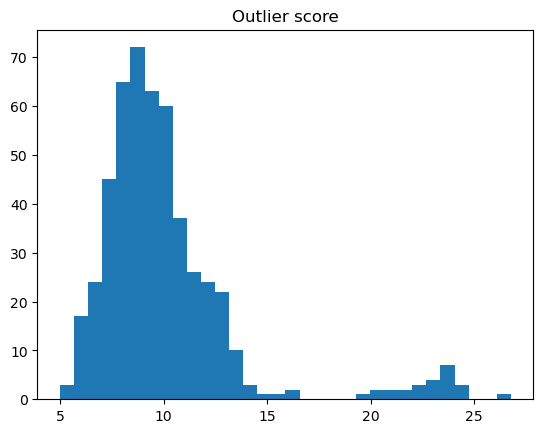

In [14]:
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

## Step 3: Profile the normal and outlier groups

We choose a threshold of 17 so that observations with the highest 5 percent of outlier scores are classified as anomalies.

In [16]:
threshold = 17 # Or other value from the above histogram
feature_list = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6']
descriptive_stat_threshold(X_train, feature_list, y_train_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,9.40
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,22.86


# Triangulate different models

When an observation is flagged as an outlier by different models, the likelihood of it being a true outlier increases significantly. This suggests that cross-validation using multiple models can enhance the robustness of our outlier
detection process.

In [22]:
########
# HBOS #
########
n_bins = 50
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)
y_train_hbos_pred = hbos.labels_
y_test_hbos_pred = hbos.predict(X_test)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_pred = ecod.labels_
y_test_ecod_pred = ecod.predict(X_test)
y_train_ecod_scores = ecod.decision_scores_  # raw outlier scores
y_test_ecod_scores = ecod.decision_function(X_test)

# Thresholds
[ecod.threshold_.item(), hbos.threshold_.item()]

[16.320821760780653, 5.563712646460526]

In [24]:
# Put the actual, the HBO score and the ECOD score together
Actual_pred = pd.DataFrame({'Actual': y_test,
                            'HBOS_pred': y_test_hbos_pred,
                            'ECOD_pred': y_test_ecod_pred})

pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,473,1
1,0,26
